In [1]:
cd /Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/

/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs


/Users/karolinegriesbach/.local/share/virtualenvs/consumption-based-costs-wGvc2ut4/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import re
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from src.utils.accounts import sanitize_account_name
from src.utils.innkeepr_api import call_api_with_service_token, send_to_innkeepr_api_paginated
from src.utils.constants import return_api_url_innkeepr

In [3]:
from_date = "2024-01-01"
to_date="2025-06-05"
timestamp = "2025-06-05 19:48:58.031710"
path_to_dir = f"/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/data/{from_date}_to_{to_date}/{timestamp}/"
path_to_save = f"/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/data/{from_date}_to_{to_date}/targeting/"
path_to_data=f"{path_to_dir}final_costs_with_azure_and_aws_and_db_{from_date}_{to_date}.csv"
url = return_api_url_innkeepr()

In [4]:
os.makedirs(path_to_save, exist_ok=True)

In [5]:
df = pd.read_csv(path_to_data)
df = df[[col for col in df.columns if "Unnamed" not in col]]
df

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_23558/412615877.py:1: DtypeWarning: Columns (4,5,6,7,8,9,12,13,14,15,17,18,19,20,22,23,24,27,28,31,38,39,40,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data)


,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.188056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.846250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.068611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.632778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
123446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
123447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
123448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123450 entries, 0 to 123449
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Deployments                     14785 non-null   object 
 1   tenant                          29142 non-null   object 
 2   deployment_node_name            5127 non-null    object 
 3   audience                        9658 non-null    object 
 4   schedule                        9658 non-null    object 
 5   use_conversion_table_targeting  8822 non-null    object 
 6   max_model_age_in_days           0 non-null       float64
 7   node_retraining_reset           0 non-null       float64
 8   Prefect_Deployments             35179 non-null   object 
 9   timestamp                       35179 non-null   object 
 10  audience_id                     27122 non-null   object 
 11  account                         35179 non-null   object 
 12  duration        

# Filter Data
Filter data for targeting runs only using Deployments and Prefect_Deployments

In [6]:
# get stackIT costs via Prefect_Deployments
targeting_runs = df[(df["Deployments"]=="targeting")|(df["Prefect_Deployments"]=="targeting")]
targeting_runs

,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
570,targeting,kfzteile24,NaN,68107275879ec174106f93d7,47 2 */3 * *,NaN,NaN,NaN,targeting,2025-05-26 14:51:50.124239,...,13.041499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,targeting,rosental,NaN,64ca4b62983ec0f8386f28f4,25 2 * * *,True,NaN,NaN,targeting,2025-05-27 00:35:21.509279,...,13.193144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580,targeting,pendix,NaN,618bc646fb99125ac1c4f584,30 3 * * *,True,NaN,NaN,targeting,2025-05-27 01:40:57.168893,...,13.193144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,targeting,asambeauty,NaN,65f301e9f7b4d736196a0ea2,2 4 * * *,True,NaN,NaN,targeting,2025-05-27 02:17:51.927019,...,13.193144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,targeting,rosental,NaN,67bc16baaaa1eaa63251f771,43 4 * * *,True,NaN,NaN,targeting,2025-05-27 02:53:39.149602,...,13.193144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32206,targeting,lillydoo,NaN,6811db64879ec17410925ee0,59 5 */3 * *,NaN,NaN,NaN,targeting,2025-05-25 04:26:47.404096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32207,targeting,asambeauty,NaN,6687da6e1767991e3bdfa9d8,20 3 */3 * *,True,NaN,NaN,targeting,2025-05-25 05:26:04.365565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32208,targeting,asambeauty,NaN,6687daf21767991e3bdfb414,4 4 */3 * *,True,NaN,NaN,targeting,2025-05-25 05:32:56.599839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32209,targeting,junoandme,NaN,67dd19baedbb1995fb715351,50 5 */3 * *,NaN,NaN,NaN,targeting,2025-05-25 12:13:52.245043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Historical count of targeting runs and prefect runs

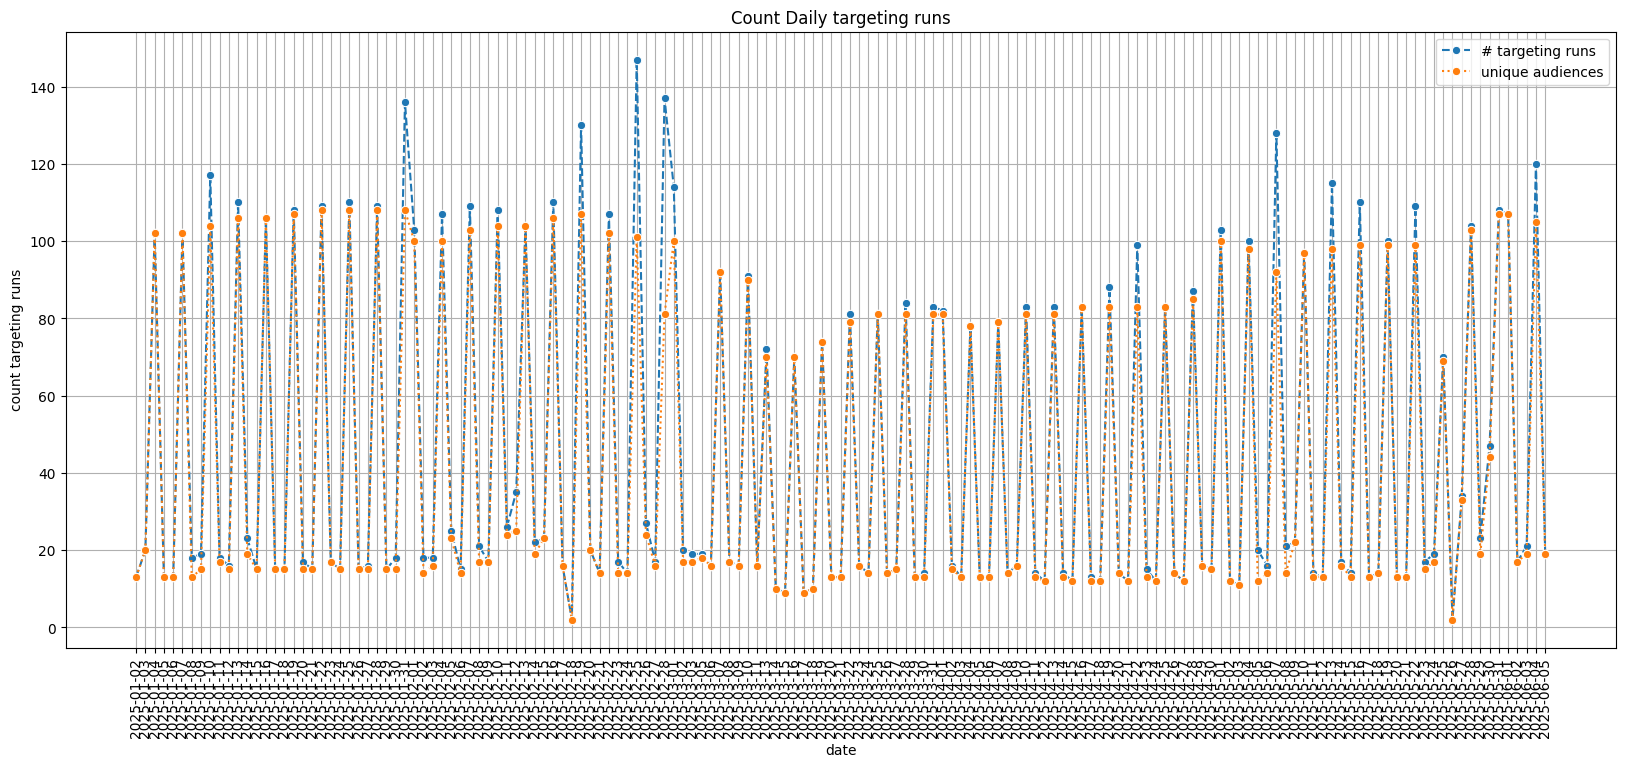

In [7]:
runs_vc_by_date = targeting_runs.groupby("date")["Prefect_Deployments"].value_counts()
runs_vc_by_date = pd.DataFrame(runs_vc_by_date).reset_index().rename(columns={"count":"count targeting runs"})
audiences_unique_by_date = targeting_runs.groupby("date")["audience_id"].nunique()
audiences_unique_by_date = pd.DataFrame(audiences_unique_by_date).reset_index()
concat = pd.merge(runs_vc_by_date, audiences_unique_by_date, on="date")
fig = plt.figure(figsize=(20,8))
sns.lineplot(
    x="date",
    y="count targeting runs",
    data=runs_vc_by_date[runs_vc_by_date["date"] > "2025-01-01"],
    marker="o",
    linestyle="--",
    label="# targeting runs"
)
sns.lineplot(
    x="date",
    y="audience_id",
    data=audiences_unique_by_date[audiences_unique_by_date["date"] > "2025-01-01"],
    marker="o",
    linestyle=":",
    label="unique audiences"
)
plt.title("Count Daily targeting runs")
plt.xticks(rotation=90)
plt.grid(True)

# Check Data Completion for node types, date and costs

In [8]:
print(len(targeting_runs))
null_values = targeting_runs[["node_name","date","charge","machine.type","audience_id","duration","total_charge_of_serviceName","audience"]].isnull().sum()
null_values = pd.DataFrame(null_values).rename(columns={0:"isnull"})
null_values["percentage_of_isnull"] = null_values["isnull"]/len(targeting_runs) * 100
null_values.sort_values(by="isnull")

23135


,isnull,percentage_of_isnull
date,0,0.000000
audience_id,0,0.000000
duration,0,0.000000
audience,13477,58.253728
node_name,22533,97.397882
charge,22552,97.480009
machine.type,22552,97.480009
total_charge_of_serviceName,22552,97.480009


## Handling Missing Data
- fehlend node_names mit existing node_names anreichern via targeting audience
- fehlende Kosten über node_names und runtime anreichern
- charges per targeting run erst ab dm 26.05.2025


In [9]:
targeting_runs[["Prefect_Deployments","audience_id","date","charge","node_name","machine.type"]]

,Prefect_Deployments,audience_id,date,charge,node_name,machine.type
570,targeting,68107275879ec174106f93d7,2025-05-26,0.057621,4cpu16gib,g1.3
579,targeting,64ca4b62983ec0f8386f28f4,2025-05-27,0.198156,4cpu16gib,g1.3
580,targeting,618bc646fb99125ac1c4f584,2025-05-27,0.198173,4cpu16gib,g1.3
581,targeting,65f301e9f7b4d736196a0ea2,2025-05-27,0.363206,4cpu16gib,g1.3
582,targeting,67bc16baaaa1eaa63251f771,2025-05-27,0.198185,4cpu16gib,g1.3
...,...,...,...,...,...,...
32206,targeting,6811db64879ec17410925ee0,2025-05-25,NaN,NaN,NaN
32207,targeting,6687da6e1767991e3bdfa9d8,2025-05-25,NaN,NaN,NaN
32208,targeting,6687daf21767991e3bdfb414,2025-05-25,NaN,NaN,NaN
32209,targeting,67dd19baedbb1995fb715351,2025-05-25,NaN,NaN,NaN


In [10]:
node_size_mapping = targeting_runs.drop_duplicates(subset=["audience_id","node_name","machine.type"])[["tenant","audience_id","node_name","machine.type"]]
# check for audiences with several nodes
vc_audience_nodes = node_size_mapping.groupby("audience_id")["node_name"].nunique()
vc_audience_nodes_more_than_one = vc_audience_nodes[vc_audience_nodes>1]
if vc_audience_nodes_more_than_one.empty == False:
    print(f"Several audiences have more than one node type: {len(vc_audience_nodes)}")
node_size_mapping

Several audiences have more than one node type: 294


,tenant,audience_id,node_name,machine.type
570,kfzteile24,68107275879ec174106f93d7,4cpu16gib,g1.3
579,rosental,64ca4b62983ec0f8386f28f4,4cpu16gib,g1.3
580,pendix,618bc646fb99125ac1c4f584,4cpu16gib,g1.3
581,asambeauty,65f301e9f7b4d736196a0ea2,4cpu16gib,g1.3
582,rosental,67bc16baaaa1eaa63251f771,4cpu16gib,g1.3
...,...,...,...,...
31122,lillydoo,6811dc7e879ec174109280ba,NaN,NaN
31127,lillydoo,6811db64879ec17410925ee0,NaN,NaN
31715,rosental,682442339a343e7007a8602c,NaN,NaN
32137,rosental,68302c5bef02595b6bea3cb5,NaN,NaN


## Query models for all active accounts

In [11]:
# query models to map audience node_name with targetingOutlook (is one of the main parameter to choose the node size)
try:
    models = pd.read_csv(f"{path_to_save}all_models.csv")
    with open(f"{path_to_save}ignore_tenants.json", "r") as f:
        ignore_tenants = json.load(f)
except FileNotFoundError:
    print("query data")
    models=pd.DataFrame()
    #min_date = targeting_runs["date"].min()
    #min_date = (pd.to_datetime(min_date)-timedelta(days=60)).strftime("%Y-%m-%d")
    ignore_tenants = []
    accounts = call_api_with_service_token(f"{url}/core/accounts/query", {}, logging)
    for tenant in targeting_runs["tenant"].unique():
        print(tenant)
        account_id = [acc["id"] for acc in accounts if sanitize_account_name(acc["name"])==tenant]
        if len(account_id) > 1:
            raise Exception(f"More than one account with name {tenant}")
        if len(account_id) == 0:
            print(f"Tenant {tenant} not found in accounts")
            ignore_tenants.append(tenant)
            continue
        account_id = account_id[0]
        temp_models = send_to_innkeepr_api_paginated(
            f"{url}/models/query",
            account_id,
            {},
            logging
        )
        temp_models = pd.json_normalize(temp_models)
        if len(temp_models) == 0:
            print(f"No models found for tenant {tenant}")
            ignore_tenants.append(tenant)
            continue
        #temp_models = temp_models[temp_models["created"]>=min_date]
        models = pd.concat([models, temp_models])
    print(models.shape)
    missing_audiences = targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]
    missing_audiences = missing_audiences[missing_audiences["audience_id"].isin(models["audience"].unique())==False]
    if missing_audiences.empty == False:
        print(f"Missing {len(missing_audiences)} models")
        print(missing_audiences[["tenant","audience_id"]].drop_duplicates())
    models.to_csv(f"{path_to_save}all_models.csv")
    with open(f"{path_to_save}ignore_tenants.json", "w") as f:
        json.dump(list(ignore_tenants), f)
models

,Unnamed: 0,id,created,path,audience,treatment,goal,targetingOutlookDays,trainingOutlookDays,f1Score,audienceSizePercentage,treatmentSessionCount,type,audienceSize,outlook,conversionLag,manualRetrainReason
0,0,6810b5789b4d943b843290fd,2025-04-29T11:18:16.896Z,kfzteile24-conversion-67ceb86f2eb78f8bcc0b643d...,681071ef879ec174106f8384,[],67ceb86f2eb78f8bcc0b643d,30.0,NaN,0.91,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
1,1,6810e57d2417934d0e8845ae,2025-04-29T16:43:09.297Z,kfzteile24-conversion-67ceb86f2eb78f8bcc0b643d...,681089fd879ec17410732ab3,[],67ceb86f2eb78f8bcc0b643d,30.0,NaN,0.91,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
2,2,6810e624d266568f9a55a4c0,2025-04-29T16:45:56.499Z,kfzteile24-conversion-67ceb86f2eb78f8bcc0b643d...,68108a15879ec17410732e25,[],67ceb86f2eb78f8bcc0b643d,30.0,NaN,0.91,0.5,0.0,conversion,150000.0,NaN,180.0,NaN
3,3,6810e67c1b14de203075126b,2025-04-29T16:47:24.050Z,kfzteile24-conversion-67ceb86f2eb78f8bcc0b643d...,68107209879ec174106f8694,[],67ceb86f2eb78f8bcc0b643d,30.0,NaN,0.91,0.5,0.0,conversion,150000.0,NaN,180.0,NaN
4,4,6810e7229b4d943b843290fe,2025-04-29T16:50:10.802Z,kfzteile24-conversion-67ceb86f2eb78f8bcc0b643d...,6810722f879ec174106f8b0b,[],67ceb86f2eb78f8bcc0b643d,30.0,NaN,0.91,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5486,291,67c3c27e640e06a4e707e607,2025-03-02T02:29:18.603Z,paulvalentine-conversion-669d6580c77d9922edbfa...,66be1d01781b51d399a63d36,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,180.0,NaN
5487,292,67c3c8687650bd81c3e8a327,2025-03-02T02:54:31.959Z,paulvalentine-conversion-669d6580c77d9922edbfa...,670921946b67f0eeded38450,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
5488,293,67c3ca4360c56cf0da9b3114,2025-03-02T03:02:26.930Z,paulvalentine-conversion-669d6580c77d9922edbfa...,66be1d6f781b51d399a64995,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
5489,294,67c3d26c640e06a4e707e60a,2025-03-02T03:37:16.087Z,paulvalentine-conversion-669d6580c77d9922edbfa...,67a4c6e9e9a9d2ef0b863db4,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,180.0,NaN


In [12]:
audiences_in_models_but_not_in_targeting_runs = models[
    (models["audience"].isin(targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]["audience_id"].unique())==False) &
    (models["created"]>=targeting_runs["date"].min())
    ]
if audiences_in_models_but_not_in_targeting_runs.empty == False:
    print(f"Found {len(audiences_in_models_but_not_in_targeting_runs)} models that are not in the targeting runs")
    raise Exception(audiences_in_models_but_not_in_targeting_runs[["audience","path","created"]])

Found 3 models that are not in the targeting runs


Exception:                      audience  \
467  65fb0acf15c25acc11bebf44   
510  65fb0a7c15c25acc11beb553   
855  65fb0b0b15c25acc11bec741   

                                                  path  \
467  rosental-conversion-63e61e29bfc19074664d8a32/2...   
510  rosental-conversion-63e61e29bfc19074664d8a32/2...   
855  rosental-conversion-63e61e29bfc19074664d8a32/2...   

                      created  
467  2024-03-21T05:14:01.146Z  
510  2024-03-21T02:55:02.651Z  
855  2024-03-21T04:31:57.849Z  

## Merge Models and Targeting Runs by considering date and targetingOutlookDays

In [13]:
models = models[["audience","created","targetingOutlookDays"]]
models.head()

,audience,created,targetingOutlookDays
0,681071ef879ec174106f8384,2025-04-29T11:18:16.896Z,30.0
1,681089fd879ec17410732ab3,2025-04-29T16:43:09.297Z,30.0
2,68108a15879ec17410732e25,2025-04-29T16:45:56.499Z,30.0
3,68107209879ec174106f8694,2025-04-29T16:47:24.050Z,30.0
4,6810722f879ec174106f8b0b,2025-04-29T16:50:10.802Z,30.0


In [14]:
models = models.rename(columns={"audience":"audience_id","created":"created_data_model_for_testing"})
# Filter data_model_for_testing to get the most recent model for each audience before the date in data_for_testing
merged_targeting_runs_with_models = pd.merge(targeting_runs, models, on='audience_id', how="left")#suffixes=('_data_for_testing', '_data_model_for_testing'))
# macht data where the model.created < data.timestamp
merged_targeting_runs_with_models_with_previous_models = merged_targeting_runs_with_models[pd.to_datetime(merged_targeting_runs_with_models['created_data_model_for_testing'],utc=True) <= pd.to_datetime(merged_targeting_runs_with_models['timestamp'],utc=True)]
merged_targeting_runs_with_models_with_previous_models = merged_targeting_runs_with_models_with_previous_models.sort_values(by='created_data_model_for_testing', ascending=False).drop_duplicates(subset=['tenant','audience_id','timestamp','node_name'], keep='first')
# get data where data.timestamp does not have a matching model
merged_targeting_runs_with_models_without_previous_models = models.groupby("audience_id")["created_data_model_for_testing"].min()
merged_targeting_runs_with_models_without_previous_models = pd.DataFrame(merged_targeting_runs_with_models_without_previous_models).reset_index()
merged_targeting_runs_with_models_without_previous_models = pd.merge(targeting_runs, merged_targeting_runs_with_models_without_previous_models, on="audience_id")
merged_targeting_runs_with_models_without_previous_models = merged_targeting_runs_with_models_without_previous_models[pd.to_datetime(merged_targeting_runs_with_models_without_previous_models['timestamp'],utc=True) <= pd.to_datetime(merged_targeting_runs_with_models_without_previous_models['created_data_model_for_testing'],utc=True)]
# concate data
merged_targeting_runs_with_models = pd.concat([merged_targeting_runs_with_models_with_previous_models, merged_targeting_runs_with_models_without_previous_models])
merged_targeting_runs_with_models = merged_targeting_runs_with_models.reset_index(drop=True)
targeting_runs_to_compare = targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]
if len(merged_targeting_runs_with_models) != len(targeting_runs_to_compare):
    raise Exception(f"Unequal length targeting_runs_to_compare {len(targeting_runs_to_compare)} vs. merged {len(merged_targeting_runs_with_models)}")
merged_targeting_runs_with_models[["tenant","audience_id","date","node_name","timestamp","created_data_model_for_testing","targetingOutlookDays"]]

,tenant,audience_id,date,node_name,timestamp,created_data_model_for_testing,targetingOutlookDays
0,lillydoo,6836dbd913526dc3d1360591,2025-06-05,4cpu16gib,2025-06-05 04:03:29.945816,2025-06-05T03:47:13.354Z,90.0
1,lillydoo,6811d9de879ec174109231bd,2025-06-05,4cpu16gib,2025-06-05 03:29:57.346328,2025-06-05T03:23:39.679Z,180.0
2,lillydoo,6836db0013526dc3d135eb7d,2025-06-05,4cpu16gib,2025-06-05 02:48:03.130822,2025-06-05T02:46:37.086Z,90.0
3,asambeauty,65f301e9f7b4d736196a0ea2,2025-06-05,4cpu16gib,2025-06-05 02:17:35.134625,2025-06-05T02:05:58.371Z,180.0
4,asambeauty,6617a6ed01c2ab3bd127f8c5,2025-06-05,4cpu16gib,2025-06-05 02:02:37.382245,2025-06-05T01:56:09.636Z,90.0
...,...,...,...,...,...,...,...
20135,lillydoo,6811db14879ec1741092565c,2025-05-04,NaN,2025-05-04 03:16:40.501630,2025-05-09T01:07:10.487Z,NaN
20136,lillydoo,6811d9de879ec174109231bd,2025-05-04,NaN,2025-05-04 03:29:15.055628,2025-05-09T03:22:54.441Z,NaN
20137,lillydoo,6811dc7e879ec174109280ba,2025-05-04,NaN,2025-05-04 03:54:14.066299,2025-05-09T02:56:16.782Z,NaN
20138,lillydoo,6811db14879ec1741092565c,2025-05-05,NaN,2025-05-05 03:16:19.695578,2025-05-09T01:07:10.487Z,NaN


In [15]:
# if dataframe does not match lenght - check why
vc_before = pd.DataFrame(targeting_runs_to_compare.groupby("audience_id")["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False).reset_index(drop=True)
vc_after = pd.DataFrame(merged_targeting_runs_with_models.groupby("audience_id")["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False).reset_index(drop=True)
if vc_after.equals(vc_before):
    print("fine")
else:
    print("not fine")

fine


# Extract node gb size and cpu

In [16]:
def extract_node_parameters(string,node_spec=None):
    if isinstance(string, str) == False:
        #print(f"String is not given")
        return None
    match = re.search(r"(\d+)cpu(\d+)gib", string)
    if match is False:
        print(f"No match found for {string}")
        return None
    elif node_spec is None:
        raise ValueError(f"Node spec needs to be cpu or gb")
    elif node_spec == "cpu":
        return int(match.group(1))
    elif node_spec == "gb":
        return int(match.group(2))
    else:
        raise ValueError(f"Node spec needs to be cpu or gb")


In [17]:
merged_targeting_runs_with_models["node_gb"] = merged_targeting_runs_with_models["node_name"].apply(lambda x: extract_node_parameters(x,node_spec="gb"))
merged_targeting_runs_with_models["node_cpu"] = merged_targeting_runs_with_models["node_name"].apply(lambda x: extract_node_parameters(x,node_spec="cpu"))
merged_targeting_runs_with_models[["tenant","audience_id","node_name","timestamp","targetingOutlookDays","node_gb","node_cpu"]]

,tenant,audience_id,node_name,timestamp,targetingOutlookDays,node_gb,node_cpu
0,lillydoo,6836dbd913526dc3d1360591,4cpu16gib,2025-06-05 04:03:29.945816,90.0,16.0,4.0
1,lillydoo,6811d9de879ec174109231bd,4cpu16gib,2025-06-05 03:29:57.346328,180.0,16.0,4.0
2,lillydoo,6836db0013526dc3d135eb7d,4cpu16gib,2025-06-05 02:48:03.130822,90.0,16.0,4.0
3,asambeauty,65f301e9f7b4d736196a0ea2,4cpu16gib,2025-06-05 02:17:35.134625,180.0,16.0,4.0
4,asambeauty,6617a6ed01c2ab3bd127f8c5,4cpu16gib,2025-06-05 02:02:37.382245,90.0,16.0,4.0
...,...,...,...,...,...,...,...
20135,lillydoo,6811db14879ec1741092565c,NaN,2025-05-04 03:16:40.501630,NaN,NaN,NaN
20136,lillydoo,6811d9de879ec174109231bd,NaN,2025-05-04 03:29:15.055628,NaN,NaN,NaN
20137,lillydoo,6811dc7e879ec174109280ba,NaN,2025-05-04 03:54:14.066299,NaN,NaN,NaN
20138,lillydoo,6811db14879ec1741092565c,NaN,2025-05-05 03:16:19.695578,NaN,NaN,NaN


## Add missing node sizes via current node size mapping
- needs a long time (to speed it up - get audiences with one specification and just iterate over audiences with several specifications)

In [19]:
node_size_mapping_with_size = merged_targeting_runs_with_models.dropna(subset=["node_name"]).drop_duplicates(subset=["audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"])[["tenant","audience_id","node_name","node_gb","node_cpu","targetingOutlookDays"]]
vc = pd.DataFrame(node_size_mapping_with_size.groupby("audience_id")["node_name"].nunique()).rename(columns={"node_name":"node_count"})
node_size_mapping_with_size = pd.merge(node_size_mapping_with_size, vc, on="audience_id", how="left")
vc_max = merged_targeting_runs_with_models.groupby(by=["audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"])["timestamp"].max().reset_index()
node_size_mapping_with_size = pd.merge(node_size_mapping_with_size, vc_max, on=["audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"], how="left")
for col in node_size_mapping_with_size.columns:
    node_size_mapping_with_size = node_size_mapping_with_size.rename(columns={col: f"{col}_nm"})
node_size_mapping_with_size

,tenant_nm,audience_id_nm,node_name_nm,node_gb_nm,node_cpu_nm,targetingOutlookDays_nm,node_count_nm,timestamp_nm
0,lillydoo,6836dbd913526dc3d1360591,4cpu16gib,16.0,4.0,90.0,1,2025-06-05 04:03:29.945816
1,lillydoo,6811d9de879ec174109231bd,4cpu16gib,16.0,4.0,180.0,1,2025-06-05 03:29:57.346328
2,lillydoo,6836db0013526dc3d135eb7d,4cpu16gib,16.0,4.0,90.0,1,2025-06-05 02:48:03.130822
3,asambeauty,65f301e9f7b4d736196a0ea2,4cpu16gib,16.0,4.0,180.0,1,2025-06-05 02:17:35.134625
4,asambeauty,6617a6ed01c2ab3bd127f8c5,4cpu16gib,16.0,4.0,90.0,2,2025-06-05 02:02:37.382245
...,...,...,...,...,...,...,...,...
121,junoandme,67dd27ccedbb1995fb73217d,4cpu16gib,16.0,4.0,90.0,2,2025-05-31 03:31:24.722270
122,beautymates,67dd1fb9edbb1995fb7217de,4cpu16gib,16.0,4.0,90.0,1,2025-06-04 00:54:01.390306
123,rosental,67bd8fcaaaa1eaa6327a5c7d,4cpu16gib,16.0,4.0,180.0,1,2025-06-05 03:57:25.409712
124,rosental,67bd9026aaa1eaa6327a68ad,4cpu16gib,16.0,4.0,180.0,1,2025-06-04 03:37:18.091264


In [20]:
merged_targeting_runs_with_models_with_node_size = pd.merge(
    merged_targeting_runs_with_models,
    node_size_mapping_with_size,
    left_on=["tenant","targetingOutlookDays"],
    right_on = ["tenant_nm","targetingOutlookDays_nm"],
    how="left"
)
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","targetingOutlookDays","node_name","node_gb","node_cpu"]+node_size_mapping_with_size.columns.tolist()]

,tenant,timestamp,audience_id,targetingOutlookDays,node_name,node_gb,node_cpu,tenant_nm,audience_id_nm,node_name_nm,node_gb_nm,node_cpu_nm,targetingOutlookDays_nm,node_count_nm,timestamp_nm
0,lillydoo,2025-06-05 04:03:29.945816,6836dbd913526dc3d1360591,90.0,4cpu16gib,16.0,4.0,lillydoo,6836dbd913526dc3d1360591,4cpu16gib,16.0,4.0,90.0,1.0,2025-06-05 04:03:29.945816
1,lillydoo,2025-06-05 04:03:29.945816,6836dbd913526dc3d1360591,90.0,4cpu16gib,16.0,4.0,lillydoo,6836db0013526dc3d135eb7d,4cpu16gib,16.0,4.0,90.0,1.0,2025-06-05 02:48:03.130822
2,lillydoo,2025-06-05 04:03:29.945816,6836dbd913526dc3d1360591,90.0,4cpu16gib,16.0,4.0,lillydoo,6811db64879ec17410925ee0,4cpu16gib,16.0,4.0,90.0,2.0,2025-06-04 04:25:13.397558
3,lillydoo,2025-06-05 04:03:29.945816,6836dbd913526dc3d1360591,90.0,4cpu16gib,16.0,4.0,lillydoo,6811dc7e879ec174109280ba,4cpu16gib,16.0,4.0,90.0,1.0,2025-06-04 03:59:48.547982
4,lillydoo,2025-06-05 04:03:29.945816,6836dbd913526dc3d1360591,90.0,4cpu16gib,16.0,4.0,lillydoo,6811dc2b879ec174109276ca,4cpu16gib,16.0,4.0,90.0,1.0,2025-06-04 01:21:09.190401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81632,lillydoo,2025-05-04 03:16:40.501630,6811db14879ec1741092565c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81633,lillydoo,2025-05-04 03:29:15.055628,6811d9de879ec174109231bd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81634,lillydoo,2025-05-04 03:54:14.066299,6811dc7e879ec174109280ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81635,lillydoo,2025-05-05 03:16:19.695578,6811db14879ec1741092565c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
merged_targeting_runs_with_models_with_node_size = merged_targeting_runs_with_models_with_node_size.sort_values(by=["tenant","audience_id","timestamp","node_gb_nm"]).drop_duplicates(subset=["tenant","audience_id","timestamp"],keep="last")
merged_targeting_runs_with_models_with_node_size["merged_node_name"] = np.where(
    merged_targeting_runs_with_models_with_node_size["node_name"].isnull(),
    merged_targeting_runs_with_models_with_node_size["node_name_nm"],
    merged_targeting_runs_with_models_with_node_size["node_name"]
)
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name"]]

,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name
81407,asambeauty,2024-02-22 01:49:47.743513,65c0f017f2e2b9b5a9ba288f,2024-02-22 01:49:47.743513,90.0,NaN,128.0,8cpu128gib
81412,asambeauty,2024-02-25 07:11:39.682486,65c0f017f2e2b9b5a9ba288f,2024-02-25 07:11:39.682486,90.0,NaN,128.0,8cpu128gib
80723,asambeauty,2024-02-28 01:48:03.158392,65c0f017f2e2b9b5a9ba288f,2024-02-28 01:48:03.158392,90.0,NaN,128.0,8cpu128gib
80708,asambeauty,2024-03-04 01:48:13.252821,65c0f017f2e2b9b5a9ba288f,2024-03-04 01:48:13.252821,90.0,NaN,128.0,8cpu128gib
80728,asambeauty,2024-03-07 02:01:09.953461,65c0f017f2e2b9b5a9ba288f,2024-03-07 02:01:09.953461,90.0,NaN,128.0,8cpu128gib
...,...,...,...,...,...,...,...,...
19364,vioneers,2025-03-07 01:16:08.928481,63d7b77d2393f1ea76dd85db,2025-03-07 01:16:08.928481,720.0,NaN,8.0,4cpu8gib
19378,vioneers,2025-03-08 01:22:31.482018,63d7b77d2393f1ea76dd85db,2025-03-08 01:22:31.482018,720.0,NaN,8.0,4cpu8gib
19366,vioneers,2025-03-09 01:25:40.733214,63d7b77d2393f1ea76dd85db,2025-03-09 01:25:40.733214,720.0,NaN,8.0,4cpu8gib
19372,vioneers,2025-03-10 01:17:24.564064,63d7b77d2393f1ea76dd85db,2025-03-10 01:17:24.564064,720.0,NaN,8.0,4cpu8gib


## Check Data Quality of Node Size Mapping

In [22]:
null_node_size_mapping = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["merged_node_name"].isnull()].drop_duplicates(subset=["tenant","targetingOutlookDays"])
null_node_size_mapping[["tenant","targetingOutlookDays","date"]]
print(f"Found {len(null_node_size_mapping)} null node size mappings")


Found 45 null node size mappings


In [23]:
merged_targeting_runs_with_models_with_node_size.to_csv(f"{path_to_save}merged_targeting_runs_with_models_with_node_size.csv", index=False)

In [24]:
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","merged_node_name","duration","charge","part_of_costs","total_charge_of_serviceName"]]

,tenant,timestamp,audience_id,merged_node_name,duration,charge,part_of_costs,total_charge_of_serviceName
81407,asambeauty,2024-02-22 01:49:47.743513,65c0f017f2e2b9b5a9ba288f,8cpu128gib,1262.484500,NaN,NaN,NaN
81412,asambeauty,2024-02-25 07:11:39.682486,65c0f017f2e2b9b5a9ba288f,8cpu128gib,1275.585200,NaN,NaN,NaN
80723,asambeauty,2024-02-28 01:48:03.158392,65c0f017f2e2b9b5a9ba288f,8cpu128gib,1275.641600,NaN,NaN,NaN
80708,asambeauty,2024-03-04 01:48:13.252821,65c0f017f2e2b9b5a9ba288f,8cpu128gib,1281.465100,NaN,NaN,NaN
80728,asambeauty,2024-03-07 02:01:09.953461,65c0f017f2e2b9b5a9ba288f,8cpu128gib,1870.886100,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
19364,vioneers,2025-03-07 01:16:08.928481,63d7b77d2393f1ea76dd85db,4cpu8gib,62.462963,NaN,NaN,NaN
19378,vioneers,2025-03-08 01:22:31.482018,63d7b77d2393f1ea76dd85db,4cpu8gib,61.794334,NaN,NaN,NaN
19366,vioneers,2025-03-09 01:25:40.733214,63d7b77d2393f1ea76dd85db,4cpu8gib,61.657307,NaN,NaN,NaN
19372,vioneers,2025-03-10 01:17:24.564064,63d7b77d2393f1ea76dd85db,4cpu8gib,61.709137,NaN,NaN,NaN


In [28]:
charge_null = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["total_charge_of_serviceName"].isnull()]
print(charge_null["date"].min(), charge_null["date"].max(), len(charge_null))
vc_charge_null = pd.DataFrame(charge_null["date"].value_counts().sort_index()).rename(columns={"count":"count_charge_null"})
vc_charge_null

2024-02-21 2025-06-05 19557


,count_charge_null
date,
2024-02-21,17
2024-02-22,53
2024-02-23,18
2024-02-24,18
2024-02-25,54
...,...
2025-05-22,109
2025-05-23,17
2025-05-24,19


In [29]:
charge_not_null = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["total_charge_of_serviceName"].notnull()]
charge_not_null["date"].min(), charge_not_null["date"].max(), len(charge_not_null)
vc_charge_not_null = pd.DataFrame(charge_not_null["date"].value_counts().sort_index()).rename(columns={"count":"count_charge_not_null"})
vc_charge_not_null

,count_charge_not_null
date,
2025-05-26,2
2025-05-27,34
2025-05-28,104
2025-05-29,23
2025-05-30,47
2025-05-31,108
2025-06-01,107
2025-06-02,17
2025-06-03,21


In [30]:
vc_charge_counts = pd.merge(vc_charge_null, vc_charge_not_null, on="date", how="outer").sort_values(by="date")
vc_charge_counts

,count_charge_null,count_charge_not_null
date,,
2024-02-21,17.0,NaN
2024-02-22,53.0,NaN
2024-02-23,18.0,NaN
2024-02-24,18.0,NaN
2024-02-25,54.0,NaN
...,...,...
2025-06-01,NaN,107.0
2025-06-02,NaN,17.0
2025-06-03,NaN,21.0


# Get targeting costs

# Playaround

In [ ]:
data_for_testing = targeting_runs[targeting_runs["tenant"]=="pendix"]
data_for_testing = data_for_testing[data_for_testing["date"]>="2025-04-01"].sort_values(by=["audience_id","date"], ascending=False)
data_for_testing[["tenant","audience_id","date","node_name","timestamp"]]

In [ ]:
data_model_for_testing = models[models["audience"].isin(data_for_testing["audience_id"].unique())]
data_model_for_testing=data_model_for_testing[data_model_for_testing["created"]>="2025-03-01"].sort_values(by=["audience","created"], ascending=False)
data_model_for_testing

In [ ]:
data_model_for_testing = data_model_for_testing.rename(columns={"audience":"audience_id","created":"created_data_model_for_testing"})
# Filter data_model_for_testing to get the most recent model for each audience before the date in data_for_testing
merged_data = pd.merge(data_for_testing, data_model_for_testing, on='audience_id', suffixes=('_data_for_testing', '_data_model_for_testing'))
merged_data = merged_data[merged_data['created_data_model_for_testing'] < merged_data['date']]
merged_data = merged_data.sort_values(by='created_data_model_for_testing', ascending=False).drop_duplicates(subset=['tenant','audience_id','timestamp','node_name'], keep='first')
merged_data[["tenant","audience_id","date","node_name","timestamp","created_data_model_for_testing","targetingOutlookDays"]]

In [ ]:
vc_before = pd.DataFrame(data_for_testing.groupby("audience_id")["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False)
vc_after = pd.DataFrame(merged_data.groupby("audience_id")["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False)
if vc_after.equals(vc_before):
    print("fine")
else:
    print("not fine")

In [ ]:
if len(data_for_testing) != len(merged_data):
    raise Exception("len(data_for_testing) != len(merged_data)")